# Tumor Detection Dataset Overview

This notebook provides a glimpse of the dataset used to train the model for tumor detection. It includes visualizations and insights into the data distribution, helping to understand the dataset better.

Source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

The dataset consists of brain MRI images categorized into the following classes. The specific view (coronal, sagittal, or axial) is not specified:

- **Glioma**: A type of tumor that occurs in the brain and spinal cord, originating from glial cells that support nerve cells.  
    - <img src="resources/images/glioma.jpg" alt="Glioma" width="150">
- **Meningioma**: Tumors that arise from the meninges, the membranes surrounding the brain and spinal cord. These are typically slow-growing and may be benign or malignant.  
    - <img src="resources/images/meningioma_1.png" alt="Meningioma 1" width="170"> <img src="resources/images/meningioma_2.jpg" alt="Meningioma 2" width="200">
- **Pituitary**: Tumors that develop in the pituitary gland, which is responsible for hormone production and regulation.  
    - <img src="resources/images/pituitary_1.jpg" alt="Pituitary 1" width="150"> <img src="resources/images/pituitary_2.png" alt="Pituitary 2" width="240">
- **NoTumor**: Images that do not show any signs of tumor presence, representing healthy brain scans.

In [6]:
import os
from typing import Tuple, List
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from common import DATA_DIR, TRAIN_DIR, TEST_DIR, IMG_SIZE, CLASS_NAMES, DEVICE, NUM_CLASSES, OUTPUT_MODELS_DIR, OUTPUT_PLOTS_DIR
from data_loader import create_data_loaders

# constants
IMG_SIZE: Tuple[int, int] = (150, 150)
BATCH_SIZE: int = 32
VALID_SPLIT: float = 0.2
EPOCHS: int = 40
os.makedirs(OUTPUT_MODELS_DIR, exist_ok=True)

In [7]:
train_loader, val_loader, test_loader = create_data_loaders()

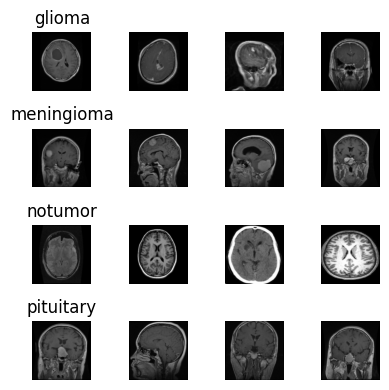

In [8]:
def get_class_samples(loader: DataLoader,
                      class_names: List[str],
                      samples_per_class: int
                      ) -> dict[str, List[torch.Tensor]]:
    samples = {c: [] for c in class_names}
    for imgs, labels in loader:
        for img, lbl in zip(imgs, labels):
            name = class_names[lbl]
            if len(samples[name]) < samples_per_class:
                samples[name].append(img)
        if all(len(v) >= samples_per_class for v in samples.values()):
            break
    return samples

def show_grid(samples: dict[str, List[torch.Tensor]], cols: int = 4) -> None:
    graphic_size = 1
    rows = len(samples)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*graphic_size, rows*graphic_size))
    for i, (cls, imgs) in enumerate(samples.items()):
        for j in range(cols):
            ax = axes[i, j]
            ax.imshow(imgs[j].permute(1,2,0))
            ax.axis("off")
            if j == 0:
                ax.set_title(cls)
    plt.tight_layout()
    plt.show()

train_samples = get_class_samples(train_loader, CLASS_NAMES, 4)
show_grid(train_samples)

# test_samples = get_class_samples(test_loader, CLASS_NAMES, 4)
# show_grid(test_samples)
